## 3(1) Feature Generation_1103_NT
20221103에 만든 Feature 중 coor_dayhourtarget을 제외한 피쳐들이다.

### Import

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import datetime
# from sklearn.manifold import TSNE
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
import warnings ; warnings.filterwarnings('ignore')

### Read Data

In [2]:
train = pd.read_parquet('/Users/hyunji/DaconJeju/clean/clean_train.parquet')
test = pd.read_parquet('/Users/hyunji/DaconJeju/clean/clean_test.parquet')

### $\blacktriangleright$ Base Feature

In [3]:
# 보류열을 제외한다.
del train['start_node_name'], train['end_node_name']
del test['start_node_name'], test['end_node_name']

In [4]:
# base_date를 날짜로 변경한다.
train['base_date'] = pd.to_datetime(train['base_date'], format='%Y%m%d')
test['base_date'] = pd.to_datetime(test['base_date'], format='%Y%m%d')

In [5]:
# Label Encoding을 수행한다.
label_col = ['day_of_week','start_turn_restricted','end_turn_restricted']
for i in label_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

In [6]:
# Mean Encoding을 수행한다.
# road_name string도 남겨야 함
mean_col = ['road_name','road_rating']
for i in mean_col:
    mean_df = train.groupby(i)['target'].agg('mean')
    train[i] = train[i].map(mean_df)
    
    for cat in np.unique(test[i]):
        if cat not in mean_df.index:
            # test에 train에 없는 범주가 나온다면 train.target.mean으로 채운다.
            mean_df.loc[cat] = train['target'].mean()
    test[i] = test[i].map(mean_df)

### $\blacktriangleright$ Feature Generation

In [7]:
feature_train, feature_test = train.copy(), test.copy()

- Date Information

In [8]:
# 월별 해당 주차를 알려주는 함수를 정의한다.
def month_week(DATE):
    standard = datetime.datetime(DATE.year,DATE.month,1)
    if standard.weekday() == 6:
        no = DATE.weekofyear - standard.isocalendar()[1] + 1
    else:
        no = DATE.weekofyear - standard.isocalendar()[1]
    return no

In [9]:
feature_train['base_year'] = train['base_date'].dt.year
feature_test['base_year'] = test['base_date'].dt.year

In [10]:
feature_train['base_month'] = train['base_date'].dt.month
feature_test['base_month'] = test['base_date'].dt.month

In [11]:
feature_train['base_day'] = train['base_date'].dt.day
feature_test['base_day'] = test['base_date'].dt.day

In [12]:
feature_train['base_no_week'] = [month_week(DATE) for DATE in train['base_date']]
feature_test['base_no_week'] = [month_week(DATE) for DATE in test['base_date']]

In [13]:
# 중복을 막기 위해 base_date는 삭제한다.
del feature_train['base_date'], feature_test['base_date']

- Transform Coordinate

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


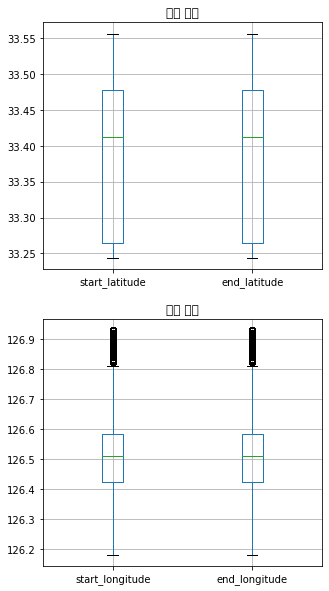

In [14]:
fig, ax = plt.subplots(2,1, figsize=(5,10))
train[['start_latitude','end_latitude']].boxplot(ax=ax[0])
train[['start_longitude','end_longitude']].boxplot(ax=ax[1])
ax[0].set_title("위도 분포")
ax[1].set_title("경도 분포")
plt.show()

In [15]:
lat_pca = PCA(n_components=1, random_state=2022).fit(train[['start_latitude','end_latitude']].values)
long_pca = PCA(n_components=1, random_state=2022).fit(train[['start_longitude','end_longitude']].values)

feature_train['pca_lat'] = lat_pca.transform(train[['start_latitude','end_latitude']].values)
feature_train['pca_long'] = long_pca.transform(train[['start_longitude','end_longitude']].values)
feature_test['pca_lat'] = lat_pca.transform(test[['start_latitude','end_latitude']].values)
feature_test['pca_long'] = long_pca.transform(test[['start_longitude','end_longitude']].values)

In [16]:
# 다중공산성을 막기 위해 제거한다.
del feature_train['start_latitude'], feature_train['start_longitude'], \
    feature_train['end_latitude'], feature_train['end_longitude']
del feature_test['start_latitude'], feature_test['start_longitude'], \
    feature_test['end_latitude'], feature_test['end_longitude']

- Calculate distance

In [17]:
# 방위각
def bearing(LAT1, LAT2, LONG1, LONG2):
    lat1, lat2, d_long = map(np.radians, (LAT1, LAT2, LONG2-LONG1))
    y = np.sin(d_long) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(d_long)
    return np.degrees(np.arctan2(y,x))

In [18]:
feature_train['harversine'] = [haversine((LAT1,LONG1),(LAT2,LONG2), unit='m') 
                               for _,LAT1,LONG1,LAT2,LONG2 in train[['start_latitude','start_longitude','end_latitude','end_longitude']].itertuples()]
feature_test['harversine'] = [haversine((LAT1,LONG1),(LAT2,LONG2), unit='m') 
                              for _,LAT1,LONG1,LAT2,LONG2 in test[['start_latitude','start_longitude','end_latitude','end_longitude']].itertuples()]

In [19]:
feature_train['bearing'] = bearing(train['start_latitude'],train['end_latitude'], train['start_longitude'],train['end_longitude'])
feature_test['bearing'] = bearing(test['start_latitude'],test['end_latitude'], test['start_longitude'],test['end_longitude'])

- coordinate label

In [20]:
label_df = train[['start_latitude','start_longitude','end_latitude','end_longitude']].drop_duplicates().reset_index(drop=True)\
           .reset_index().set_index(['start_latitude','start_longitude','end_latitude','end_longitude']).rename(columns={'index':'coordinate_label'})

for label in test[['start_latitude','start_longitude','end_latitude','end_longitude']].drop_duplicates().values:
    if tuple(label) not in label_df.index:
        label_df.loc[tuple(label)] = label_df['coordinate_label'].max()+1
        
train = pd.merge(train, label_df.reset_index(), on=['start_latitude','start_longitude','end_latitude','end_longitude'])
test = pd.merge(test, label_df.reset_index(), on=['start_latitude','start_longitude','end_latitude','end_longitude'])

feature_train = pd.merge(feature_train, train[['id','coordinate_label']], on='id')
feature_test = pd.merge(feature_test, test[['id','coordinate_label']], on='id')

- Mean Target

In [21]:
mean_df = train.groupby('coordinate_label')['target'].agg('mean')
train['coordinate_target'] = train['coordinate_label'].map(mean_df)

for cat in np.unique(test['coordinate_label']):
    if cat not in mean_df.index:
        # test에 train에 없는 범주가 나온다면 train.target.mean으로 채운다.
        mean_df.loc[cat] = train['target'].mean()
test['coordinate_target'] = test['coordinate_label'].map(mean_df)

feature_train = pd.merge(feature_train, train[['id','coordinate_target']], on='id')
feature_test = pd.merge(feature_test, test[['id','coordinate_target']], on='id')

In [22]:
# mean_df = train.groupby(['day_of_week','base_hour','coordinate_label'])['target'].mean().rename('coor_dayhourtarget')

# for label in test[['day_of_week','base_hour','coordinate_label']].drop_duplicates().values:
#     if tuple(label) not in mean_df.index:
#         mean_df.loc[tuple(label)] = train.target.mean()
        
# train = pd.merge(train, mean_df.reset_index(), on=['day_of_week','base_hour','coordinate_label'])
# test = pd.merge(test, mean_df.reset_index(), on=['day_of_week','base_hour','coordinate_label'])

# feature_train = pd.merge(feature_train, train[['id','coor_dayhourtarget']], on='id')
# feature_test = pd.merge(feature_test, test[['id','coor_dayhourtarget']], on='id')

- Sum cnt_times, lnt_times

In [22]:
feature_train['sum_cnt_times'] = train[[i for i in train.columns if "cnt_times" in i]].sum(axis=1)
feature_train['sum_lnt_times'] = train[[i for i in train.columns if "lnt_times" in i]].sum(axis=1)

feature_test['sum_cnt_times'] = test[[i for i in test.columns if "cnt_times" in i]].sum(axis=1)
feature_test['sum_lnt_times'] = test[[i for i in test.columns if "lnt_times" in i]].sum(axis=1)

### Confirm Data

In [23]:
feature_train

,id,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,weight_restricted,...,base_day,base_no_week,pca_lat,pca_long,harversine,bearing,coordinate_label,coordinate_target,sum_cnt_times,sum_lnt_times
0,TRAIN_0000000,1,17,1,48.021548,47.291909,0,0,60.0,32400.0,...,23,3,0.061420,0.199099,25.710651,-89.628639,0,51.756910,0.0,0.0
1,TRAIN_0000001,1,21,2,46.388468,39.990158,0,0,60.0,0.0,...,28,4,0.167519,0.008463,525.890585,-30.359277,1,26.400712,0.0,0.0
2,TRAIN_0000002,4,7,2,46.388468,44.365146,0,0,80.0,0.0,...,10,1,-0.148080,-0.221065,608.398971,-80.243779,2,59.101720,0.0,0.0
3,TRAIN_0000003,0,13,2,34.701408,25.030004,0,0,50.0,0.0,...,11,1,-0.195860,0.063678,107.352194,-122.270455,3,25.024923,0.0,0.0
4,TRAIN_0000004,6,8,2,46.388468,43.530979,0,0,80.0,0.0,...,5,1,0.110490,-0.273421,337.949009,81.247401,4,39.873670,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,TRAIN_4701212,1,16,1,34.701408,44.774556,0,0,50.0,0.0,...,4,0,0.052654,-0.347546,427.004280,-108.050664,646,27.620482,0.0,0.0
4701213,TRAIN_4701213,1,2,2,34.701408,44.774556,0,0,80.0,43200.0,...,31,4,0.124731,-0.137264,48.463884,87.352999,614,68.900580,0.0,0.0
4701214,TRAIN_4701214,3,22,2,46.388468,43.530979,0,0,60.0,0.0,...,13,2,0.086740,0.553062,342.184748,174.259616,811,32.028164,0.0,0.0
4701215,TRAIN_4701215,2,2,2,46.388468,70.443438,0,0,80.0,0.0,...,20,3,0.084823,-0.126028,209.716367,42.083750,664,54.208822,0.0,0.0


In [24]:
feature_test

,id,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,weight_restricted,...,base_day,base_no_week,pca_lat,pca_long,harversine,bearing,coordinate_label,coordinate_target,sum_cnt_times,sum_lnt_times
0,TEST_000000,1,17,3,34.701408,35.053946,0,0,70.0,0.0,...,25,3,0.163741,0.029526,278.927299,57.548612,668,33.623164,0.0,0.0
1,TEST_000001,6,12,2,46.388468,43.530979,0,0,70.0,0.0,...,9,1,-0.178197,-0.141800,1038.940963,-92.375196,279,48.359276,0.0,0.0
2,TEST_000002,0,2,1,46.388468,44.365146,0,0,60.0,0.0,...,5,0,-0.177109,-0.065184,171.442611,-80.815071,332,59.993453,0.0,0.0
3,TEST_000003,1,23,3,46.388468,39.990158,0,0,70.0,0.0,...,18,2,0.124395,0.033754,271.087580,-176.467172,60,33.185444,0.0,0.0
4,TEST_000004,2,17,3,48.021548,50.719692,0,0,70.0,0.0,...,10,1,0.162427,0.075713,1225.872066,114.738656,724,46.299654,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291236,TEST_291236,5,5,1,46.388468,44.365146,0,0,80.0,0.0,...,27,3,0.123509,-0.084501,329.352532,-142.045440,297,42.992907,0.0,0.0
291237,TEST_291237,0,20,2,46.388468,39.990158,0,0,60.0,0.0,...,19,2,-0.114890,0.110214,524.186844,165.438411,124,54.120437,0.0,0.0
291238,TEST_291238,0,11,1,34.701408,25.642498,0,0,30.0,0.0,...,5,0,0.157323,-0.035117,431.332410,2.181071,314,29.095771,0.0,0.0
291239,TEST_291239,0,7,2,34.701408,24.686785,0,0,60.0,0.0,...,12,1,-0.182570,-0.020528,101.935927,16.920179,838,23.185020,0.0,0.0


In [31]:
print('------------결측치------------')
display(feature_train.isna().sum())
display(feature_test.isna().sum())

------------결측치------------


id                       0
day_of_week              0
base_hour                0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
weight_restricted        0
road_type                0
start_turn_restricted    0
end_turn_restricted      0
target                   0
start_cluster            0
end_cluster              0
enforce                  0
cnt_30                   0
cnt_times_30             0
cnt_50                   0
lnt_50                   0
cnt_times_50             0
lnt_times_50             0
cnt_60                   0
lnt_60                   0
cnt_times_60             0
lnt_times_60             0
cnt_70                   0
cnt_times_70             0
cnt_80                   0
lnt_80                   0
cnt_times_80             0
lnt_times_80             0
child                    0
protect_cnt              0
protect_lnt              0
length                   0
s

id                       0
day_of_week              0
base_hour                0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
weight_restricted        0
road_type                0
start_turn_restricted    0
end_turn_restricted      0
start_cluster            0
end_cluster              0
enforce                  0
cnt_30                   0
cnt_times_30             0
cnt_50                   0
lnt_50                   0
cnt_times_50             0
lnt_times_50             0
cnt_60                   0
lnt_60                   0
cnt_times_60             0
lnt_times_60             0
cnt_70                   0
cnt_times_70             0
cnt_80                   0
lnt_80                   0
cnt_times_80             0
lnt_times_80             0
child                    0
protect_cnt              0
protect_lnt              0
length                   0
speed                    0
t

### Save Data

In [26]:
date = str(pd.Timestamp.now())[:10].replace('-','')
feature_train.to_csv(f'.../clean/feature/{date}_train_2.csv', index=False)
feature_test.to_csv(f'../clean/feature/{date}_test_2.csv', index=False)